In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense
from tensorflow.keras.preprocessing.image import  ImageDataGenerator

2023-07-10 20:09:00.845593: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-10 20:09:00.948049: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-10 20:09:02.105694: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2023-07-10 20:09:04.027574: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-07-10 20:09:04.346417: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-07-10 20:09:04.348071: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


**Transfer Learning:** We will now use the same cats vs dogs dataset but using a pretrained model called "InceptionV3" which is available through keras.applications.

In [3]:
# download dataset
!wget --no-check-certificate https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip


/bin/bash: /home/tanzid/miniconda3/envs/tf/lib/libtinfo.so.6: no version information available (required by /bin/bash)
--2023-07-10 17:05:29--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.68.128, 142.251.10.128, 172.217.194.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.68.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘cats_and_dogs_filtered.zip.2’

  cats_and_dogs_fil  38%[======>             ]  25.29M  2.40MB/s    eta 18s    ^C


In [3]:
# extract the compressed files and save in current directory
import zipfile
import os

local = './cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local, 'r')
zip_ref.extractall()

# specify file paths to data
base_dir = './cats_and_dogs_filtered/' 
train_dir = os.path.join(base_dir, 'train') 
validation_dir = os.path.join(base_dir, 'validation')
train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')
validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

print(f"Total number of cat training images: {len(os.listdir(train_cats_dir))}")
print(f"Total number of dog training images: {len(os.listdir(train_dogs_dir))}")
print(f"Total number of cat validation images: {len(os.listdir(validation_cats_dir))}")
print(f"Total number of dog validation images: {len(os.listdir(validation_dogs_dir))}")
print(os.listdir(train_dogs_dir)[:10])
print(os.listdir(validation_cats_dir)[:10])

target_img_height = target_img_width = 150 
color_channels = 3

# initialize data generators (normalize image pixel values)
train_datagen = ImageDataGenerator(rescale= 1.0/255.0,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')
validation_datagen = ImageDataGenerator(rescale= 1.0/255.0)

# create stream of image batches
train_generator = train_datagen.flow_from_directory(train_dir, batch_size=20, class_mode='binary', target_size=(target_img_height,target_img_width))

validation_generator = validation_datagen.flow_from_directory(validation_dir, batch_size=20, class_mode='binary', target_size=(target_img_height,target_img_width))

Total number of cat training images: 1000
Total number of dog training images: 1000
Total number of cat validation images: 500
Total number of dog validation images: 500
['dog.105.jpg', 'dog.674.jpg', 'dog.356.jpg', 'dog.376.jpg', 'dog.142.jpg', 'dog.81.jpg', 'dog.1.jpg', 'dog.682.jpg', 'dog.150.jpg', 'dog.686.jpg']
['cat.2283.jpg', 'cat.2390.jpg', 'cat.2296.jpg', 'cat.2392.jpg', 'cat.2352.jpg', 'cat.2317.jpg', 'cat.2405.jpg', 'cat.2318.jpg', 'cat.2182.jpg', 'cat.2455.jpg']
Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [6]:
# Download the pre-trained weights. No top means it excludes the fully connected layer it uses for classification.
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O ./inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

/bin/bash: /home/tanzid/miniconda3/envs/tf/lib/libtinfo.so.6: no version information available (required by /bin/bash)
--2023-07-10 20:12:25--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.68.128, 74.125.200.128, 142.251.10.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.68.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘./inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

./inception_v3_weig 100%[===================>]  83.84M  2.37MB/s    in 37s     

2023-07-10 20:13:02 (2.27 MB/s) - ‘./inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



Set up separate image data generators for training and validation images and preprocessing. We will also pass in image augmentation parameters to the training images generator.

In [8]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import layers

# model weights file path
weights_filepath = './inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

# initialize the pre-trained model (remove the dense layer using include_top flag)
pretrained_model = InceptionV3(input_shape=(150,150,3), include_top=False, weights=None)

# load the downloaded weights
pretrained_model.load_weights(weights_filepath)

# freeze the weights in every layer
for layer in pretrained_model.layers:
    layer.trainable = False

2023-07-10 20:17:15.281918: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-07-10 20:17:15.283499: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-07-10 20:17:15.284946: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-07-10 20:17:18.277486: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-07-10 20:17:18.278536: I tensorflow/compile

In [9]:
pretrained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 74, 74, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 74, 74, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                       

Instead of using all the layers of this model, we will only use all layers up to layer 'mixed7', i.e. we're excluding some of the convolutional layers at the end because we need the higher level features to be fine-tuned to our particular task/dataset

In [10]:
# choose 'mixed7' as the last layer
last_layer = pretrained_model.get_layer('mixed7')
print(f"Last layer output shape: {last_layer.output_shape}")
last_output = last_layer.output

# create a custom model which takes the output from this last layer from InceptionV3 and feeds it into some layers and an output layer that we specify: last_layer --> Flatten --> Dense --> Dropout --> Dense
x = layers.Flatten()(last_output)
x = layers.Dense(units=1024, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(units=1, activation='sigmoid')(x)
model = tf.keras.Model(pretrained_model.input, x)

model.summary()

Last layer output shape: (None, 7, 7, 768)
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 74, 74, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 74, 74, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                   

In [11]:
# compile and train the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [12]:
history = model.fit(train_generator, validation_data=validation_generator, steps_per_epoch=100, epochs=20, validation_steps=50, verbose=2)

Epoch 1/20


2023-07-10 20:35:12.691664: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-07-10 20:35:16.675912: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-07-10 20:35:18.294948: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-07-10 20:35:19.454979: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x343b9070 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-07-10 20:35:19.455014: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA GeForce RTX 4070 Laptop GPU, Compute Capability 8.9
2023-07-10 20:35:1

100/100 - 14s - loss: 0.5268 - accuracy: 0.8715 - val_loss: 0.1270 - val_accuracy: 0.9560 - 14s/epoch - 136ms/step
Epoch 2/20
100/100 - 6s - loss: 0.2212 - accuracy: 0.9090 - val_loss: 0.1989 - val_accuracy: 0.9400 - 6s/epoch - 60ms/step
Epoch 3/20
100/100 - 6s - loss: 0.1892 - accuracy: 0.9330 - val_loss: 0.0869 - val_accuracy: 0.9630 - 6s/epoch - 60ms/step
Epoch 4/20
100/100 - 6s - loss: 0.1687 - accuracy: 0.9335 - val_loss: 0.1113 - val_accuracy: 0.9530 - 6s/epoch - 60ms/step
Epoch 5/20
100/100 - 6s - loss: 0.1659 - accuracy: 0.9310 - val_loss: 0.1381 - val_accuracy: 0.9460 - 6s/epoch - 62ms/step
Epoch 6/20
100/100 - 6s - loss: 0.1500 - accuracy: 0.9390 - val_loss: 0.0853 - val_accuracy: 0.9640 - 6s/epoch - 57ms/step
Epoch 7/20
100/100 - 6s - loss: 0.1575 - accuracy: 0.9380 - val_loss: 0.0901 - val_accuracy: 0.9650 - 6s/epoch - 57ms/step
Epoch 8/20
100/100 - 6s - loss: 0.1314 - accuracy: 0.9480 - val_loss: 0.0985 - val_accuracy: 0.9580 - 6s/epoch - 57ms/step
Epoch 9/20
100/100 - 6s 

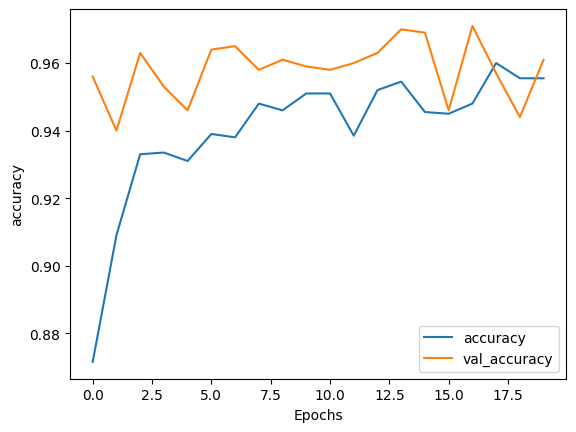

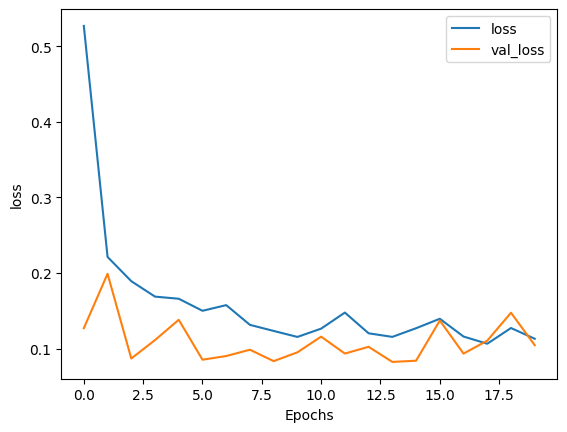

In [13]:
import matplotlib.pyplot as plt 

# lets now plot some learning curves
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history["val_"+metric])
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, "val_"+metric])
    plt.show()

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

This model reaches almost 97% validation accuracy demonstrating the power of transfer learning!